In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import random

In [14]:
class PermutedMNIST(Dataset):
    """Form the permuted MNIST"""
    def __init__(self, permutation, task_id, train=True):
        dataset = torchvision.datasets.MNIST(root='data', train=train, download=True)
        self.images = dataset.data[:1000].unsqueeze(1).numpy()
        self.targets = dataset.targets[:1000]
        self.permutation = permutation
        self.task_id = torch.Tensor([task_id])
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.50], std=[0.25])
        ])

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image, target = self.images[idx], self.targets[idx]
        image = self.transform(image)
        image = image.flatten(0, -1)[self.permutation]
        return image, target, self.task_id

In [15]:
class MLP(nn.Module):
    """a simple MLP architecture
    """
    def __init__(self, in_dim=28*28, out_dim=10, hidden_dim=100):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    
class taskMLP(nn.Module):
    """a simple MLP architecture
    """
    def __init__(self, in_dim=28*28, out_dim=10, hidden_dim=100, tdim=40):
        super(taskMLP, self).__init__()
        self.fc1 = nn.Linear(in_dim + tdim , hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        self.relu = nn.ReLU()
        self.tdim = tdim

    def forward(self, x, t):
        t = F.one_hot(t.long(), self.tdim).squeeze()
        x = torch.cat([x, t], dim=-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [16]:
def set_seed(acorn):
    """set random seed"""
    random.seed(acorn)
    np.random.seed(acorn)
    torch.manual_seed(acorn)
    torch.cuda.manual_seed(acorn)
    torch.cuda.manual_seed_all(acorn)

def get_dataloader(train_dataset, test_dataset):
    trainloader = DataLoader(
        train_dataset,
        batch_size=10,
        shuffle=True,
        drop_last=False
    )
    testloader = DataLoader(
        test_dataset, 
        batch_size=100,
        shuffle=False
    )
    return trainloader, testloader

class Trainer:
    """trainer class for the models"""
    def __init__(self, model, train_loader, optimizer, device, verbose=False):
        self.model = model
        self.train_loader = train_loader

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optimizer

        self.device = device
        self.verbose = verbose

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0.0
        
        for batch in self.train_loader:
            batch = [b.to(self.device) for b in batch]
            x, y, t = batch

            logits = self.model(x, t)
            loss = self.criterion(logits.squeeze(), y)
            self.optimizer.zero_grad()  
            loss.backward()  

            self.optimizer.step() 
            total_loss += loss.item()

        return total_loss / len(self.train_loader)

    def evaluate(self, model=None, test_loader=None):
        if model:
            self.model = model
        self.model.eval()
        errors = []
        with torch.no_grad():
            for batch in test_loader:
                batch = [b.to(self.device) for b in batch]
                x, y, t = batch
                logits = self.model(x, t)
                probs = torch.softmax(logits, dim=1)
                err = (probs.argmax(dim=1) != y).float()
                errors.append(err.cpu().numpy())
        errors = np.concatenate(errors)
        return 1 - np.mean(errors)

    def train(self, num_epochs):
        progress_bar = tqdm(range(num_epochs), desc="Training", unit="epoch")
        for epoch in progress_bar:
            train_loss = self.train_one_epoch()
            if self.verbose:
                progress_bar.set_description(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {train_loss:.4f}")

In [17]:
# set_seed(1996)

In [23]:
T = 20
num_epochs = 10

tasks = [torch.randperm(28*28) for _ in range(T)]

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

methods = ["taskMLP"]

current_task_acc = {method : [] for method in methods}
initial_task_acc = {method : [] for method in methods}

for method in methods:
    if method == "MLP":
        model = MLP()
    elif method == "taskMLP":
        model = taskMLP()
    else:
        raise NotImplementedError
    model.to(device)

    for t in range(T):
        print(f"Training on task {t}...")

        train_dataset = PermutedMNIST(tasks[t], (t+1),  train=True)
        test_dataset = PermutedMNIST(tasks[t], (t+1), train=False)

        trainloader, testloader = get_dataloader(train_dataset, test_dataset)

        if t == 0:
            initial_task_testloader = deepcopy(testloader)

        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr=0.03
        )

        trainer = Trainer(model, trainloader, optimizer, device, verbose=True)
        trainer.train(num_epochs=num_epochs)

        curr_acc = trainer.evaluate(test_loader=initial_task_testloader)
        initial_acc = trainer.evaluate(test_loader=testloader)

        print(f"Accuracy on task {t+1}: {curr_acc:.3f}")
        print(f"Accuracy on task 1: {initial_acc:.3f}")

        current_task_acc[method].append(curr_acc)
        initial_task_acc[method].append(initial_acc)


Training on task 0...


Epoch [10/10] - Loss: 0.1445: 100%|██████████| 10/10 [00:02<00:00,  4.17epoch/s]


Accuracy on task 1: 0.864
Accuracy on task 1: 0.864
Training on task 1...


Epoch [10/10] - Loss: 0.1143: 100%|██████████| 10/10 [00:02<00:00,  3.98epoch/s]


Accuracy on task 2: 0.664
Accuracy on task 1: 0.851
Training on task 2...


Epoch [10/10] - Loss: 0.1460: 100%|██████████| 10/10 [00:02<00:00,  4.27epoch/s]


Accuracy on task 3: 0.512
Accuracy on task 1: 0.832
Training on task 3...


Epoch [10/10] - Loss: 0.2405: 100%|██████████| 10/10 [00:02<00:00,  4.25epoch/s]


Accuracy on task 4: 0.354
Accuracy on task 1: 0.823
Training on task 4...


Epoch [10/10] - Loss: 0.2898: 100%|██████████| 10/10 [00:02<00:00,  3.92epoch/s]


Accuracy on task 5: 0.407
Accuracy on task 1: 0.835
Training on task 5...


Epoch [10/10] - Loss: 0.2900: 100%|██████████| 10/10 [00:02<00:00,  3.89epoch/s]


Accuracy on task 6: 0.262
Accuracy on task 1: 0.755
Training on task 6...


Epoch [10/10] - Loss: 0.3106: 100%|██████████| 10/10 [00:02<00:00,  4.13epoch/s]


Accuracy on task 7: 0.319
Accuracy on task 1: 0.782
Training on task 7...


Epoch [10/10] - Loss: 0.2288: 100%|██████████| 10/10 [00:02<00:00,  3.84epoch/s]


KeyboardInterrupt: 

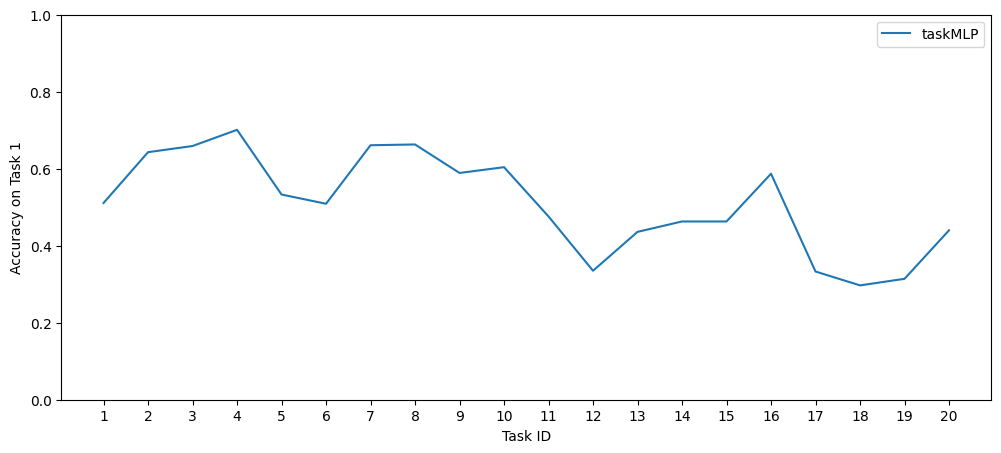

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))
for method in methods:
    ax.plot(np.arange(1, T+1), initial_task_acc[method], label=method)
ax.set_xlabel("Task ID")
ax.set_ylabel("Accuracy on Task 1")
ax.set_ylim([0, 1])
ax.set_xticks(np.arange(1, T+1))
ax.legend()
plt.show()